In [58]:
from ultralytics import YOLO
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2
import torch
import os

In [34]:
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)

In [35]:
import matplotlib.pyplot as plt
def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  #Define COCO Labels
  
  if labels == []:
   names = ['Audi', 'Chrysler', 'Citroen', 'GMC', 'Honda', 'Hyundai', 'Infiniti', 'Mazda', 'Mercedes', 'Mercury', 'Mitsubishi', 'Nissan', 'Renault', 'Toyota', 'Volkswagen', 'acura', 'bmw', 'cadillac', 'chevrolet', 'dodge', 'ford', 'jeep', 'kia', 'lexus', 'lincoln', 'mini', 'porsche', 'ram', 'range rover', 'skoda', 'subaru', 'suzuki', 'volvo']
   labels = {i: name for i, name in enumerate(names)}
  #Define colors
  if colors == []:
    #colors = [(6, 112, 83), (253, 246, 160), (40, 132, 70), (205, 97, 162), (149, 196, 30), (106, 19, 161), (127, 175, 225), (115, 133, 176), (83, 156, 8), (182, 29, 77), (180, 11, 251), (31, 12, 123), (23, 6, 115), (167, 34, 31), (176, 216, 69), (110, 229, 222), (72, 183, 159), (90, 168, 209), (195, 4, 209), (135, 236, 21), (62, 209, 199), (87, 1, 70), (75, 40, 168), (121, 90, 126), (11, 86, 86), (40, 218, 53), (234, 76, 20), (129, 174, 192), (13, 18, 254), (45, 183, 149), (77, 234, 120), (182, 83, 207), (172, 138, 252), (201, 7, 159), (147, 240, 17), (134, 19, 233), (202, 61, 206), (177, 253, 26), (10, 139, 17), (130, 148, 106), (174, 197, 128), (106, 59, 168), (124, 180, 83), (78, 169, 4), (26, 79, 176), (185, 149, 150), (165, 253, 206), (220, 87, 0), (72, 22, 226), (64, 174, 4), (245, 131, 96), (35, 217, 142), (89, 86, 32), (80, 56, 196), (222, 136, 159), (145, 6, 219), (143, 132, 162), (175, 97, 221), (72, 3, 79), (196, 184, 237), (18, 210, 116), (8, 185, 81), (99, 181, 254), (9, 127, 123), (140, 94, 215), (39, 229, 121), (230, 51, 96), (84, 225, 33), (218, 202, 139), (129, 223, 182), (167, 46, 157), (15, 252, 5), (128, 103, 203), (197, 223, 199), (19, 238, 181), (64, 142, 167), (12, 203, 242), (69, 21, 41), (177, 184, 2), (35, 97, 56), (241, 22, 161)]
    colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]
  
  #plot each boxes
  for box in boxes:
    #add score in label if score=True
    if score :
      label = labels[int(box[-1])] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])]
    #filter every box under conf threshold if conf threshold setted
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        box_label(image, box, label, color)
    else:
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  #show image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  try:
    import google.colab
    IN_COLAB = True
  except:
    IN_COLAB = False

  if IN_COLAB:
    cv2_imshow(image) #if used in Colab
  else :
    plt.imshow(image)
    


0: 480x640 (no detections), 139.6ms
Speed: 3.0ms preprocess, 139.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 416x640 1 dodge, 115.4ms
Speed: 3.0ms preprocess, 115.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 Renault, 113.8ms
Speed: 5.5ms preprocess, 113.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Renault, 157.7ms
Speed: 5.4ms preprocess, 157.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x512 1 Renault, 131.0ms
Speed: 3.0ms preprocess, 131.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


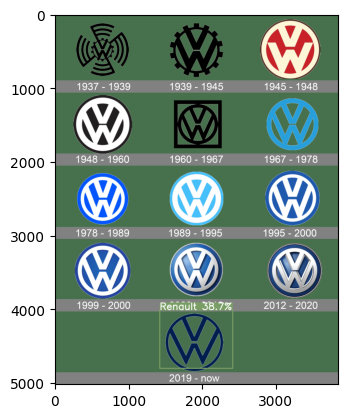

In [64]:
model = YOLO("best.pt")
folder_path = "TestImg"
image_data = []  # to store the image data

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):  # check if the item is a file
        image = cv2.imread(file_path)  # read the image
        image_data.append(image)  # append the image data to the list or dictionary

for i in image_data:
    results = model.predict(i)
    # show the image with the bounding boxes
    show_results(i, results, score=True, conf=0.3)
# response = requests.get("https://s3-prod-europe.autonews.com/s3fs-public/styles/width_792/public/2022%20mitsubishi%20Outlander_0.jpg")
# image = Image.open(BytesIO(response.content))
# image = np.asarray(image)
# results = model.predict(image)
# print(results[0].boxes.data)

# for video

# model = YOLO("best.pt")
# videolink = "https://www.youtube.com/watch?v=YGvkLKtVBI4&ab_channel=KrystianAndraka"
# cap = cv2.VideoCapture(videolink)
# while True:
#   ret, frame = cap.read()
#   if ret == False:
#     break
#   results = model.predict(frame)
#   show_results(frame, results, score=True, conf=0.3)
#   if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()



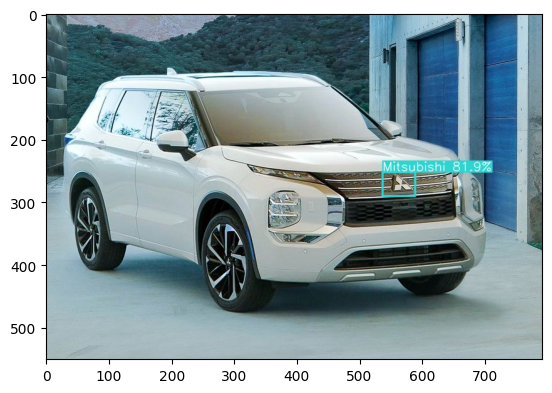